In [16]:
# 设置支持中文的字体，比如 SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
# 正确显示负号
plt.rcParams['axes.unicode_minus'] = False   

生成样本数据...
嵌入水印...
检测原始数据中的水印...
原始数据水印检测结果: 无水印 (绿色区间比例: 54.96%)
检测水印数据中的水印...
水印数据水印检测结果: 有水印 (绿色区间比例: 76.33%)
可视化数据分布...


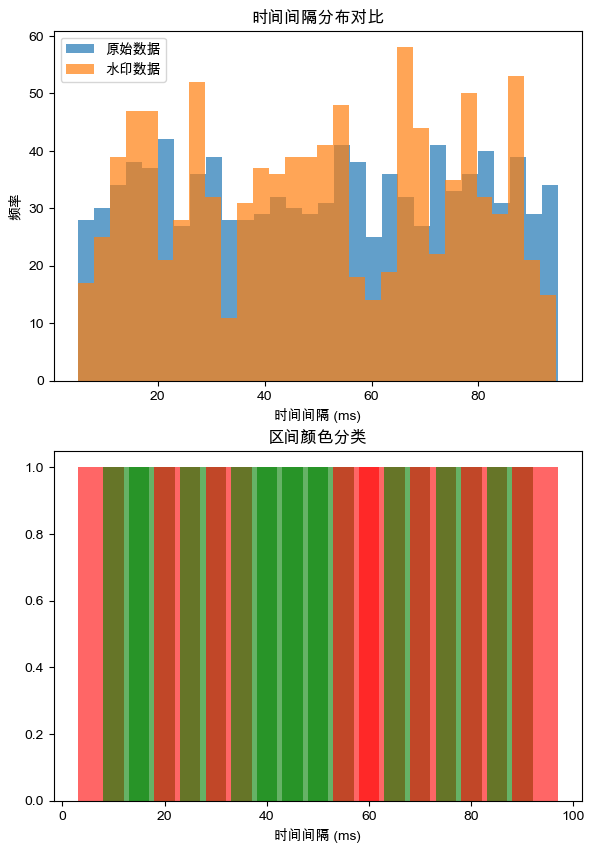

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import random
from typing import List, Tuple, Dict
import seaborn as sns

class TimeIntervalWatermark:
    """时间间隔水印系统"""
    
    def __init__(self, seed_interval_count: int = 5, nearby_green_count: int = 3, select_green_ratio: float = 0.6, change_pro: float = 0.5):
        """
        初始化水印系统
        
        参数:
            seed_interval_count: 用于生成种子的时间间隔数量
            nearby_green_count: 修改红色区间时，选择的邻近绿色区间数量
        """
        self.seed_interval_count = seed_interval_count
        self.nearby_green_count = nearby_green_count
        self.select_green_ratio = select_green_ratio # 选择绿色区间比例
        self.change_prob = change_pro # 红色区间修改为绿色的几率
        self.bins = []  # 时间区间列表
        self.time = 5 # 时间区间长度ms
        self.discrete_values = []  # 对应的离散值
        self.bin_colors = {}  # 区间颜色映射
        
    def _calculate_bins(self, data: List[float]) -> None:
        """
        根据数据计算时间区间列表
        
        参数:
            data: 时间间隔数据列表
        """
        min_val = min(data)
        max_val = max(data)
        
        # 向下取整到倍数
        min_bin = int(min_val / self.time) * self.time
        # 向上取整到倍数
        max_bin = (int(max_val / self.time) + 1) * self.time
        
        # 划分时间区间列表
        self.bins = list(range(min_bin, max_bin + self.time, self.time))
        # 生成对应的离散值
        self.discrete_values = [bin_val // self.time for bin_val in self.bins]
        
    def _get_discrete_value(self, interval: float) -> int:
        """
        获取时间间隔对应的离散值
        
        参数:
            interval: 时间间隔
        
        返回:
            对应的离散值
        """
        return int(interval // self.time)
    
    def _get_bin_index(self, discrete_value: int) -> int:
        """
        获取离散值在区间列表中的索引
        
        参数:
            discrete_value: 离散值
        
        返回:
            索引位置
        """
        try:
            return self.discrete_values.index(discrete_value)
        except ValueError:
            # 如果不在列表中，返回最接近的索引
            closest_index = min(range(len(self.discrete_values)), 
                               key=lambda i: abs(self.discrete_values[i] - discrete_value))
            return closest_index
    
    def _generate_seed(self, intervals: List[float]) -> int:
        """
        根据前n个时间间隔生成哈希种子
        
        参数:
            intervals: 时间间隔列表
        
        返回:
            生成的种子
        """
        seed_intervals = intervals[:self.seed_interval_count]
        # 将浮点数转换为字符串并连接
        interval_str = "".join([str(int(i * 1000)) for i in seed_intervals])
        # 生成哈希值
        hash_value = hashlib.md5(interval_str.encode()).hexdigest()
        # 转换为整数作为种子
        return int(hash_value, 16) % (2**32)
    
    def _classify_bins(self, seed: int) -> None:
        """
        根据种子将区间分为红绿两类
        
        参数:
            seed: 随机数种子
        """
        random.seed(seed)
        
        # 创建区间索引列表
        bin_indices = list(range(len(self.bins) - 1))
        # 随机打乱
        random.shuffle(bin_indices)
        
        # 将一定比例作为绿色区间，剩余作为红色区间
        green_count = int(len(bin_indices) * self.select_green_ratio)
        green_indices = set(bin_indices[:green_count])
        
        # 创建区间颜色映射
        self.bin_colors = {}
        for i in range(len(self.bins) - 1):
            if i in green_indices:
                self.bin_colors[i] = "green"
            else:
                self.bin_colors[i] = "red"
    
    def _find_nearby_green_bins(self, bin_index: int) -> List[int]:
        """
        找到附近的k个绿色区间
        
        参数:
            bin_index: 当前区间索引
        
        返回:
            附近绿色区间的索引列表
        """
        green_bins = [i for i, (idx, color) in enumerate(self.bin_colors.items()) 
                     if color == "green" and i != bin_index]
        
        if not green_bins:
            return []
        
        # 按照与当前区间的距离排序
        sorted_green_bins = sorted(green_bins, key=lambda x: abs(x - bin_index))
        # 返回最近的k个绿色区间
        return sorted_green_bins[:self.nearby_green_count]
    
    def _get_random_value_in_bin(self, bin_index: int) -> float:
        """
        在指定区间内生成随机值
        
        参数:
            bin_index: 区间索引
        
        返回:
            区间内的随机值
        """
        bin_start = self.bins[bin_index]
        bin_end = self.bins[bin_index + 1]
        return random.uniform(bin_start, bin_end - 0.001)  # 避免取到上界
    
    def embed_watermark(self, intervals: List[float]) -> List[float]:
        """
        在时间间隔数据中嵌入水印
        
        参数:
            intervals: 原始时间间隔数据
        
        返回:
            嵌入水印后的时间间隔数据
        """
        
        # 计算区间
        self._calculate_bins(intervals)
        
        # 生成种子
        seed = self._generate_seed(intervals)
        
        # 区间分类
        self._classify_bins(seed)
        
        # 准备嵌入水印
        watermarked_intervals = intervals.copy()
        
        # 前n个用于种子生成的间隔保持不变
        for i in range(self.seed_interval_count, len(intervals)):
            interval = intervals[i]
            discrete_value = self._get_discrete_value(interval)
            bin_index = self._get_bin_index(discrete_value)
            
            # 如果是红色区间，修改为附近绿色区间的随机值
            if bin_index < len(self.bins) - 1 and self.bin_colors.get(bin_index) == "red" and random.random() < self.change_prob:
                # 找到附近的绿色区间
                nearby_green_bins = self._find_nearby_green_bins(bin_index)
                if nearby_green_bins:
                    # 随机选择一个绿色区间
                    selected_bin = random.choice(nearby_green_bins)
                    # 在选定的绿色区间内生成随机值
                    watermarked_intervals[i] = self._get_random_value_in_bin(selected_bin)
        
        return watermarked_intervals
    
    def detect_watermark(self, intervals: List[float], threshold: float = 0.70) -> bool:
        """
        检测是否存在水印
        
        参数:
            intervals: 待检测的时间间隔数据
            threshold: 绿色区间比例阈值
        
        返回:
            是否检测到水印
        """
        # 计算区间
        self._calculate_bins(intervals)
        
        # 生成种子
        seed = self._generate_seed(intervals)
        
        # 区间分类
        self._classify_bins(seed)
        
        # 统计绿色区间占比
        green_count = 0
        total_count = 0
        
        # 跳过用于种子生成的数据
        for i in range(self.seed_interval_count, len(intervals)):
            interval = intervals[i]
            discrete_value = self._get_discrete_value(interval)
            bin_index = self._get_bin_index(discrete_value)
            
            if bin_index < len(self.bins) - 1:  # 确保索引有效
                total_count += 1
                if self.bin_colors.get(bin_index) == "green":
                    green_count += 1
        
        green_ratio = green_count / total_count if total_count > 0 else 0
        
        return green_ratio >= threshold, green_ratio
    
    def visualize_data(self, original_intervals: List[float], watermarked_intervals: List[float]) -> None:
        """
        可视化原始数据和水印数据的分布
        
        参数:
            original_intervals: 原始时间间隔数据
            watermarked_intervals: 嵌入水印后的时间间隔数据
        """
        plt.figure(figsize=(15, 10))
        
        # 1. 绘制原始数据和水印数据的直方图对比
        plt.subplot(2, 2, 1)
        plt.hist(original_intervals, bins=30, alpha=0.7, label="原始数据")
        plt.hist(watermarked_intervals, bins=30, alpha=0.7, label="水印数据")
        plt.legend()
        plt.title("时间间隔分布对比")
        plt.xlabel("时间间隔 (ms)")
        plt.ylabel("频率")
        
        # 3. 绘制时间区间颜色分类
        plt.subplot(2, 2, 3)
        bin_centers = [(self.bins[i] + self.bins[i+1])/2 for i in range(len(self.bins)-1)]
        bin_colors_list = ["green" if self.bin_colors.get(i) == "green" else "red" for i in range(len(self.bins)-1)]
        plt.bar(bin_centers, [1]*len(bin_centers), width=9, color=bin_colors_list, alpha=0.6)
        plt.title("区间颜色分类")
        plt.xlabel("时间间隔 (ms)")


def generate_sample_data(n: int = 1000, min_val: float = 10.0, max_val: float = 100.0) -> List[float]:
    """
    生成模拟样本数据
    
    参数:
        n: 样本数量
        min_val: 最小值
        max_val: 最大值
    
    返回:
        生成的样本数据列表
    """

    # 均匀分布
    data = np.random.uniform(min_val, max_val, n)
    
    return data.tolist()


def main():
    """主函数，演示水印系统的使用"""
    # 生成样本数据
    print("生成样本数据...")
    sample_data = generate_sample_data(n=1000, min_val=5.0, max_val=95.0)
    
    # 创建水印系统
    watermark_system = TimeIntervalWatermark(seed_interval_count=3, nearby_green_count=3)
    
    # 嵌入水印
    print("嵌入水印...")
    watermarked_data = watermark_system.embed_watermark(sample_data)
    
    # 检测水印
    print("检测原始数据中的水印...")
    has_watermark_original, green_ratio_original = watermark_system.detect_watermark(sample_data)
    print(f"原始数据水印检测结果: {'有水印' if has_watermark_original else '无水印'} (绿色区间比例: {green_ratio_original:.2%})")
    
    print("检测水印数据中的水印...")
    has_watermark, green_ratio = watermark_system.detect_watermark(watermarked_data)
    print(f"水印数据水印检测结果: {'有水印' if has_watermark else '无水印'} (绿色区间比例: {green_ratio:.2%})")
    
    # 可视化数据
    print("可视化数据分布...")
    watermark_system.visualize_data(sample_data, watermarked_data)


if __name__ == "__main__":
    main()